In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.style as mplstyle
import datetime
import statistics


#for list of style plt.style.available (https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#mplstyle.use('bmh')

In [2]:
customer_profiles_df=pd.read_csv("./data/customer_profiles_table.csv")
transactions_df=pd.read_csv("./data/transactions_df.csv", parse_dates=["TX_DATETIME"])
terminal_profiles_df=pd.read_csv("./data/terminal_profiles_table.csv")

# Exploratory data analysis

This project will use a data set generator created by [Yann-Aël Le Borgne & Gianluca Bontempi](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html). The generator will create three dataset that reproduce the logs of a fictional card company, including fraudulent transactions. 

The logs are split in three dataset, column name in lower case are directly linked to the main dataset **transactions_df**:

1 - Customer profile

| Column | Type | Description |
| --- | --- | --- |
| CUSTOMER_ID | int64 | The customer unique ID|
|(x_customer_id,y_customer_id) | float64 | A pair of real coordinates (x_customer_id,y_customer_id) in a 100 * 100 grid, that defines the geographical location of the customer |
|(mean_amount, std_amount) | float64 | The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.|
| mean_nb_tx_per_day | float64 | The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4) |

The generate_customer_profiles_table function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer.

In [3]:
customer_profiles_df.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",78
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[5, 160, 242, 378, 431, 475, 571, 762, 876, 93...",85
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[316, 406, 447, 523, 968, 1200, 1318, 1365, 16...",70
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[65, 94, 113, 364, 401, 433, 485, 651, 672, 77...",70
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[372, 614, 774, 1362, 1446, 1564, 1637, 1939, ...",65


In [4]:
customer_profiles_df.shape

(5000, 8)

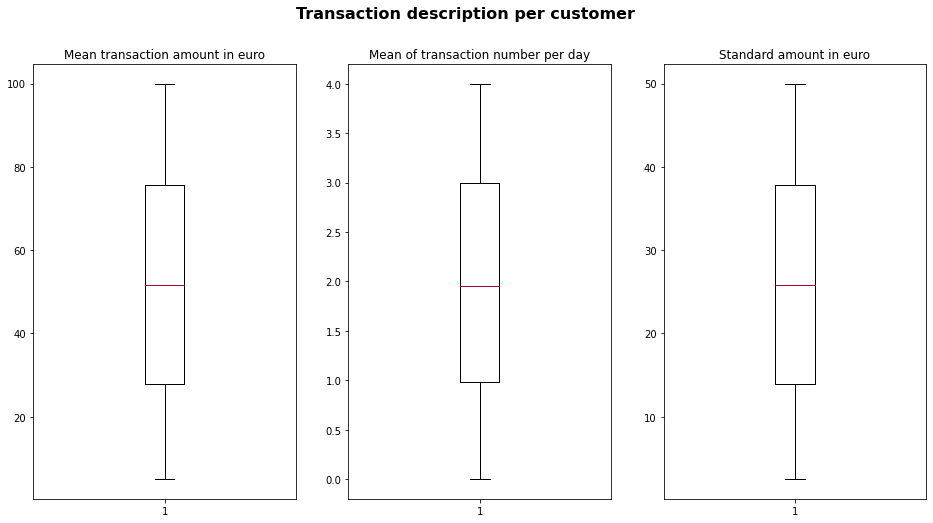

In [5]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
mplstyle.use('bmh')
fig.suptitle("Transaction description per customer", fontsize=16, fontweight='bold')

ax[0].boxplot(customer_profiles_df["mean_amount"])
ax[1].boxplot(customer_profiles_df["mean_nb_tx_per_day"])
ax[2].boxplot(customer_profiles_df["std_amount"])

ax[0].title.set_text("Mean transaction amount in euro")
ax[1].title.set_text("Mean of transaction number per day")
ax[2].title.set_text("Standard amount in euro")


plt.show()

2 - Terminal profile

| Column | Type | Description |
| --- | --- | --- |
| TERMINAL_ID | int64 | The terminal ID|
| (x_terminal_id,y_terminal_id) | float64 | A pair of real coordinates (x_terminal_id,y_terminal_id) in a 100 * 100 grid, that defines the geographical location of the terminal|

The generate_terminal_profiles_table function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal.

In [6]:
terminal_profiles_df.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673


In [7]:
terminal_profiles_df.shape

(10000, 3)

3 - Transaction list


| Column | Type | Description |
| --- | --- | --- |
| TRANSACTION_ID  | int64 | A unique identifier for the transaction|
| TX_DATETIME  | object | Date and time at which the transaction occurs|
| CUSTOMER_ID  | int64 | The identifier for the customer. Each customer has a unique identifier|
| TERMINAL_ID  | int64 | The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier|
| TX_AMOUNT	  | int64 | The amount of the transaction|
| TX_FRAUD  | int64 | A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction|
| TX_FRAUD_SCENARIO | int64 | Referencing the fraud scenario, 0 indicate a genuine transaction|

* Fraud scenario:

Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. 

Scenario 2: Every day, a list of 6 terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. 

Scenario 3: Every day, a list of 6 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. 

Scenario 4 : Every day a list of 4 customer is drawn at random. In the next 3 days every transaction have their amount multiplied by a random number between 3 and 6. This scenario simulate a hit and run scenario where fraudster try to exit as much funds as possible before being detected.

In [8]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [9]:
#Fraud repartition

transactions_df_temp = transactions_df.groupby("TX_FRAUD_SCENARIO").count()
transactions_df_temp["percentage"] = (transactions_df_temp[["TX_FRAUD"]]/
                                      transactions_df_temp[["TX_FRAUD"]].sum())*100
transactions_df_temp[["TX_FRAUD","percentage"]]

,TX_FRAUD,percentage
TX_FRAUD_SCENARIO,,
0,1738126,99.086227
1,972,0.055411
2,9067,0.516887
3,3907,0.222728
4,2083,0.118747


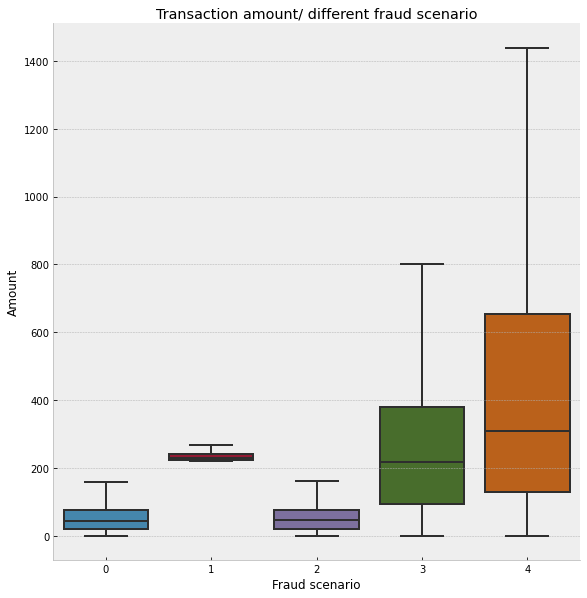

In [10]:
sns.displot(color = "rocket", height=8)

ax = sns.boxplot(x = "TX_FRAUD_SCENARIO",y = "TX_AMOUNT", data= transactions_df, showfliers = False)
ax.set_title("Transaction amount/ different fraud scenario")
ax.set_ylabel("Amount")
ax.set_xlabel("Fraud scenario");

In [11]:
#convert the transactions_df.TX_DATETIME column to a mor
pop = pd.to_datetime(transactions_df["TX_DATETIME"], format='%Y, %m, %d').dt.date
transactions_df_temp = transactions_df
transactions_df_temp["temp_date"] = pop

In [12]:
scn_0 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 0]
scn_1 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 1]
scn_2 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 2]
scn_3 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 3]
scn_4 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 4]
scn_fraud = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO != 0]

In [13]:
temp_0_sum = scn_0.resample("d", on="TX_DATETIME").sum()
temp_1_sum = scn_1.resample("d", on="TX_DATETIME").sum()
temp_2_sum = scn_2.resample("d", on="TX_DATETIME").sum()
temp_3_sum = scn_3.resample("d", on="TX_DATETIME").sum()
temp_4_sum = scn_4.resample("d", on="TX_DATETIME").sum()
temp_fraud_sum = scn_fraud.resample("d", on="TX_DATETIME").sum()

temp_0_count = scn_0.resample("d", on="TX_DATETIME").count()
temp_1_count = scn_1.resample("d", on="TX_DATETIME").count()
temp_2_count = scn_2.resample("d", on="TX_DATETIME").count()
temp_3_count = scn_3.resample("d", on="TX_DATETIME").count()
temp_4_count = scn_4.resample("d", on="TX_DATETIME").count()
temp_fraud_count = scn_fraud.resample("d", on="TX_DATETIME").sum()

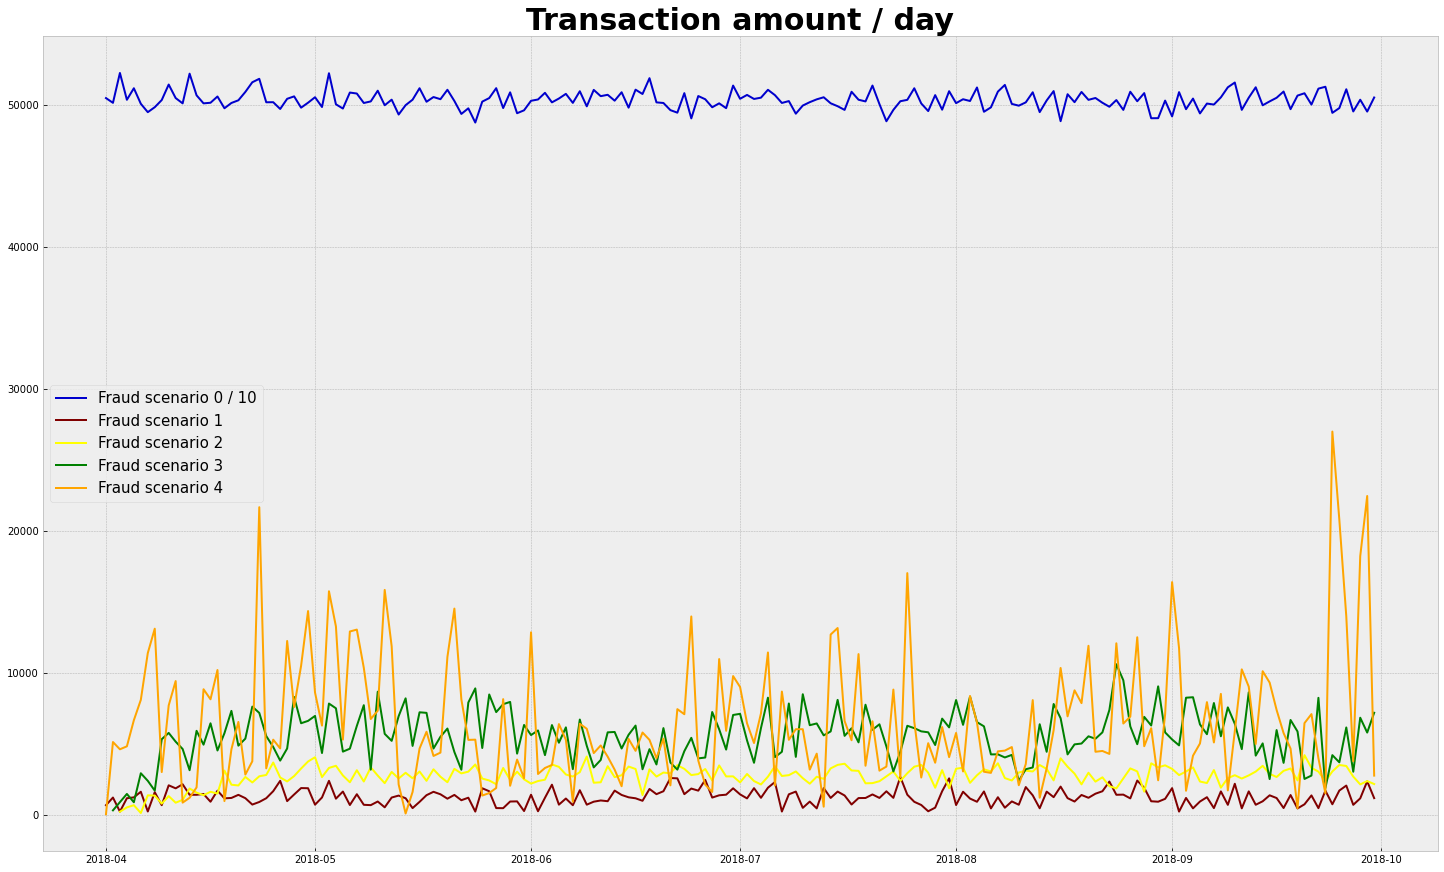

In [14]:
fig, ax=plt.subplots(figsize=(25, 15))
mplstyle.use('bmh')
plt.plot(temp_0_sum.index  , (temp_0_sum.TX_AMOUNT/10),label="Fraud scenario 0 / 10", color = "mediumblue")
plt.plot(temp_1_sum.index, temp_1_sum.TX_AMOUNT,label="Fraud scenario 1",color = "maroon")
plt.plot(temp_2_sum.index, temp_2_sum.TX_AMOUNT,label="Fraud scenario 2",color = "yellow")
plt.plot(temp_3_sum.index, temp_3_sum.TX_AMOUNT,label="Fraud scenario 3",color = "green")
plt.plot(temp_4_sum.index, temp_4_sum.TX_AMOUNT,label="Fraud scenario 4",color ="orange")

plt.title("Transaction amount / day", fontsize=30, fontweight='bold')
ax.legend(fontsize=15)
plt.show()

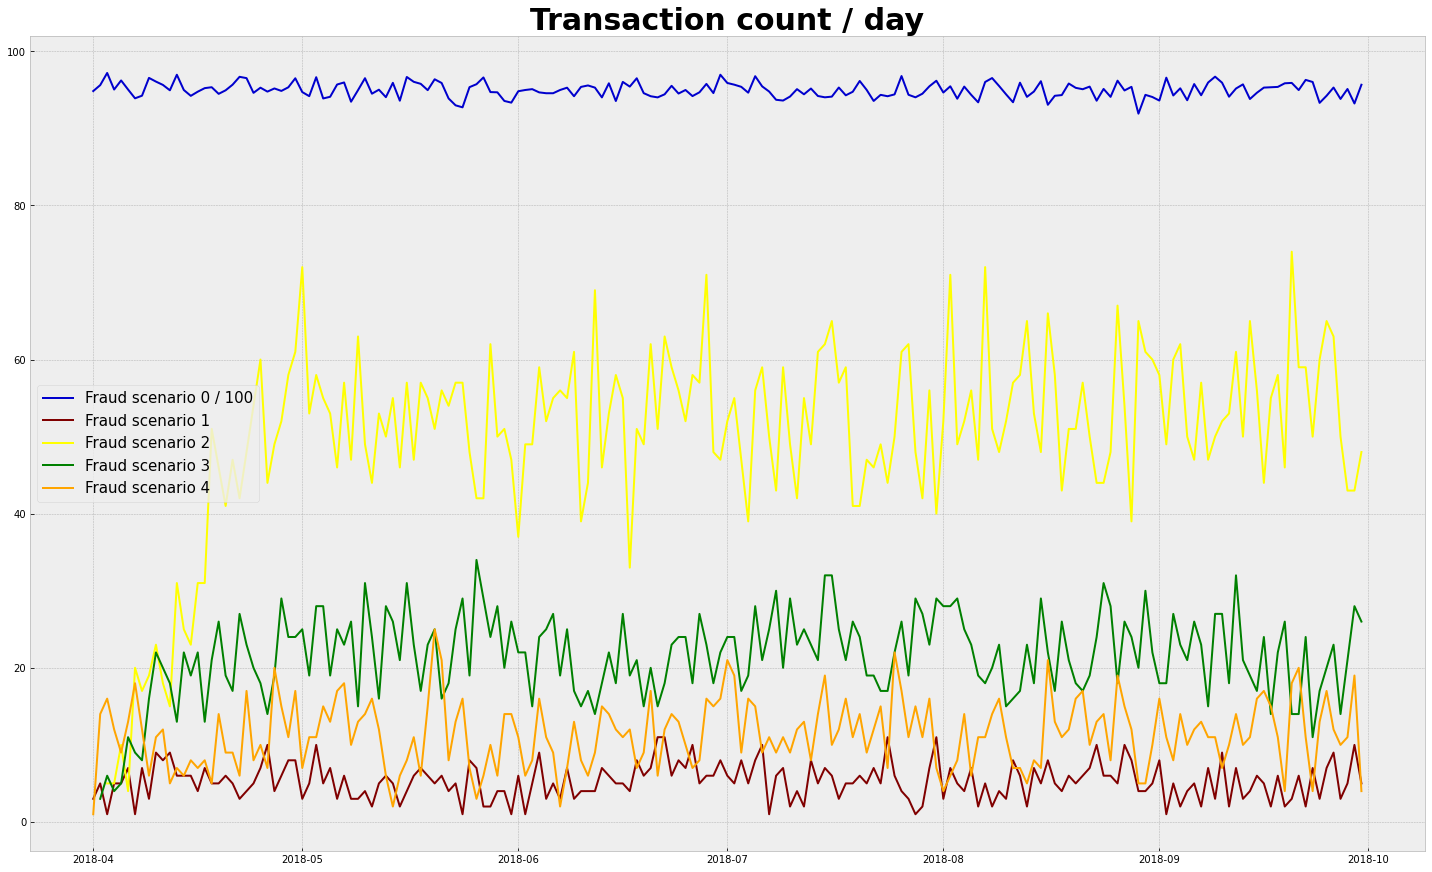

In [15]:
fig, ax=plt.subplots(figsize=(25, 15))


plt.plot(temp_0_count.index, (temp_0_count.TX_AMOUNT/100),label="Fraud scenario 0 / 100", color = "mediumblue")
plt.plot(temp_1_count.index, temp_1_count.TX_AMOUNT,label="Fraud scenario 1",color = "maroon")
plt.plot(temp_2_count.index, temp_2_count.TX_AMOUNT,label="Fraud scenario 2",color = "yellow")
plt.plot(temp_3_count.index, temp_3_count.TX_AMOUNT,label="Fraud scenario 3",color = "green")
plt.plot(temp_4_count.index, temp_4_count.TX_AMOUNT,label="Fraud scenario 4",color ="orange")

plt.title("Transaction count / day", fontsize=30, fontweight='bold')
ax.legend(fontsize=15)
plt.show()

# Dataframe transformation

In [16]:
from datetime import datetime

#date transaformation
# could be optimised
def func_date_monday (data1):
  
    if data1.weekday() == 0:
        return 1
    else:
        return 0
    
def func_date_tuesday (data1):
   
    if data1.weekday() == 1:
        return 1
    else:
        return 0

def func_date_wednesday (data1):
    
    if data1.weekday() == 2:
        return 1
    else:
        return 0
def func_date_thursday (data1):
    
    if data1.weekday() == 3:
        return 1
    else:
        return 0
def func_date_friday (data1):
   
    if data1.weekday() == 4:
        return 1
    else:
        return 0
def func_date_saturday (data1):
    
    if data1.weekday() == 5:
        return 1
    else:
        return 0
def func_date_sunday (data1):
   
    if data1.weekday() == 6:
        return 1
    else:
        return 0

In [17]:
# could be optimised
transactions_df["is_monday"]=transactions_df.TX_DATETIME.apply(func_date_monday);
transactions_df["is_tuesday"]=transactions_df.TX_DATETIME.apply(func_date_tuesday);
transactions_df["is_wednesday"]=transactions_df.TX_DATETIME.apply(func_date_wednesday);
transactions_df["is_thursday"]=transactions_df.TX_DATETIME.apply(func_date_thursday);
transactions_df["is_friday"]=transactions_df.TX_DATETIME.apply(func_date_friday);
transactions_df["is_saturday"]=transactions_df.TX_DATETIME.apply(func_date_saturday);
transactions_df["is_sunday"]=transactions_df.TX_DATETIME.apply(func_date_sunday)

In [18]:
def timestamp1(data1):

    if data1.hour <=6:
        return 1
    else:
        return 0
    
def timestamp2(data1):
   
    if data1.hour >6 and data1.hour <= 12:
        return 1
    else:
        return 0
def timestamp3(data1):
  
    if data1.hour >12 and data1.hour <= 18:
        return 1
    else:
        return 0
def timestamp4(data1):
  
    if data1.hour >18:
        return 1
    else:
        return 0

In [19]:
transactions_df["hour_1_4"]=transactions_df.TX_DATETIME.apply(timestamp1)
transactions_df["hour_2_4"]=transactions_df.TX_DATETIME.apply(timestamp2)
transactions_df["hour_3_4"]=transactions_df.TX_DATETIME.apply(timestamp3)
transactions_df["hour_4_4"]=transactions_df.TX_DATETIME.apply(timestamp4)

In [20]:
def tran_hist (temp_tran_id, window_days):
#sort transaction id by date time and reindex the df
    
    transaction_id_temp_df = temp_tran_id.sort_values("TX_DATETIME")
    transaction_id_temp_df.index = transaction_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        sum_tran_period = transaction_id_temp_df["TX_AMOUNT"].rolling(str(period) + "d").sum()
        count_tran_period =transaction_id_temp_df["TX_AMOUNT"].rolling(str(period)+"d").count()
        average_tran_period = sum_tran_period/count_tran_period
        
        transaction_id_temp_df["average_tx_last"+ str(period) + "days"] = average_tran_period
        transaction_id_temp_df["tx_count_over_last"+ str(period) + "days"] = count_tran_period


    return transaction_id_temp_df

In [21]:
# create columns with rolling transaction history 
temp_bis_df=transactions_df.groupby("CUSTOMER_ID").apply(lambda x: tran_hist(x, window_days=[1,7,30]))
temp_bis_df=temp_bis_df.sort_values("TX_TIME_SECONDS").reset_index(drop=True)
transactions_df = temp_bis_df

In [22]:
def terminal_hist (terminal_id, window_days, period_uncertainty = 10):

#sort terminaid by date time and reindex the df
    
    terminal_id_temp_df = terminal_id.sort_values("TX_DATETIME")
    terminal_id_temp_df.index = terminal_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        count_genuine_tran_period = terminal_id_temp_df["TX_FRAUD"].rolling(min_periods= period_uncertainty, 
                                                                            window = (str(period) + "d")).count()
        count_fraudulent__tran_period =terminal_id_temp_df["TX_FRAUD"].rolling(str(period)+"d").sum()
        fraud_rate_period = count_fraudulent__tran_period/count_genuine_tran_period
        
        terminal_id_temp_df["average_terminal_fraud_rate_last"+ str(period) + "days"] = fraud_rate_period


    return terminal_id_temp_df

In [23]:
temp_bis_df=transactions_df.groupby("TERMINAL_ID").apply(lambda x: terminal_hist(x, window_days =[15,30]))
temp_bis_df=temp_bis_df.sort_values("TX_TIME_SECONDS").reset_index(drop=True)
transactions_df = temp_bis_df

In [24]:
transactions_df = transactions_df.fillna(0)

In [25]:
transactions_df.sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,temp_date,...,hour_3_4,hour_4_4,average_tx_last1days,tx_count_over_last1days,average_tx_last7days,tx_count_over_last7days,average_tx_last30days,tx_count_over_last30days,average_terminal_fraud_rate_last15days,average_terminal_fraud_rate_last30days
1623907,1623907,2018-09-17 10:56:01,3027,4181,73.83,14640961,169,0,0,2018-09-17,...,0,0,52.260000,3.0,46.778125,16.0,57.606301,73.0,0.0,0.000
1188568,1188568,2018-08-02 21:12:34,4660,9424,15.12,10703554,123,0,0,2018-08-02,...,0,1,16.325000,2.0,26.223333,15.0,25.738452,84.0,0.0,0.000
1616397,1616397,2018-09-16 13:54:56,4638,2731,5.49,14565296,168,0,0,2018-09-16,...,1,0,5.490000,1.0,13.947778,9.0,13.600312,32.0,0.0,0.000
1387626,1387626,2018-08-23 15:48:50,617,5023,10.72,12498530,144,0,0,2018-08-23,...,1,0,21.950000,2.0,22.630000,14.0,20.826842,57.0,0.0,0.000
111462,111461,2018-04-12 13:48:54,2283,5500,37.70,1000134,11,0,0,2018-04-12,...,1,0,28.783333,3.0,33.852000,25.0,30.255500,40.0,0.0,0.000
383967,383967,2018-05-10 23:10:04,3847,9078,8.07,3453004,39,0,0,2018-05-10,...,0,1,16.672857,7.0,18.497500,24.0,20.408235,85.0,0.0,0.000
862466,862466,2018-06-29 20:08:44,1054,9984,24.77,7762124,89,0,0,2018-06-29,...,0,1,38.466667,3.0,41.956000,10.0,48.207818,55.0,0.0,0.000
1731380,1731380,2018-09-28 13:40:09,225,9548,17.44,15601209,180,0,0,2018-09-28,...,1,0,17.910000,2.0,14.013333,3.0,17.005455,11.0,0.0,0.000
612543,612543,2018-06-03 17:42:55,4791,9972,91.95,5506975,63,0,0,2018-06-03,...,1,0,97.473333,3.0,97.473333,3.0,81.982000,15.0,0.0,0.025
997839,997839,2018-07-14 03:09:36,551,3427,88.44,8996976,104,0,0,2018-07-14,...,0,0,41.170000,3.0,52.249333,15.0,56.254819,83.0,0.0,0.000


# Machine learning

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X=transactions_df[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days']]  # Features
y=transactions_df['TX_FRAUD'] 

In [28]:
%time X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

CPU times: user 508 ms, sys: 136 ms, total: 645 ms
Wall time: 742 ms


In [29]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
%time model.fit(X_train,y_train)
%time y_pred=model.predict(X_test)

CPU times: user 9min 37s, sys: 3.83 s, total: 9min 41s
Wall time: 1min 19s
CPU times: user 2.34 s, sys: 72.7 ms, total: 2.41 s
Wall time: 351 ms


In [30]:
print ("Training Score:",model.score(X_train,y_train))
print ("Test Score:",model.score(X_test,y_test))

Training Score: 0.9999968329153838
Test Score: 0.9982669767866101


In [31]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
%time print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9982669767866101
CPU times: user 6.16 ms, sys: 924 µs, total: 7.09 ms
Wall time: 5.95 ms


No handles with labels found to put in legend.


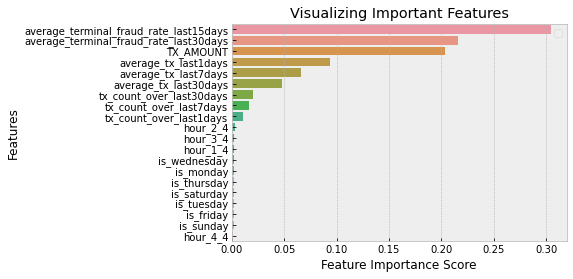

In [32]:
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

looking for the granular details

In [33]:
result = pd.DataFrame(data=transactions_df.TRANSACTION_ID, columns=["TRANSACTION_ID"])
result.insert(1, "TX_FRAUD_SCENARIO", transactions_df.TX_FRAUD_SCENARIO, True)
result.insert(1, "TX_FRAUD", transactions_df.TX_FRAUD, True)
result.insert(1, "TX_AMOUNT", transactions_df.TX_AMOUNT, True)

In [34]:
result.head(10)

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,57.16,0,0
1,1,81.51,0,0
2,2,146.00,0,0
3,3,64.49,0,0
4,4,50.99,0,0
5,5,44.71,0,0
6,6,96.03,0,0
7,7,24.36,0,0
8,8,26.34,0,0
9,9,59.07,0,0


In [35]:
prediction = X
%time tem_p = model.predict(X)
%time tem_p_2 = model.predict_proba(X)[:,1]
result.insert(1, "fraud_prediction", tem_p, True)
result.insert(1, "fraud_prediction_rate", tem_p_2, True)

CPU times: user 22.8 s, sys: 649 ms, total: 23.5 s
Wall time: 3.91 s
CPU times: user 22.9 s, sys: 386 ms, total: 23.2 s
Wall time: 3.75 s


In [36]:
result.head()

,TRANSACTION_ID,fraud_prediction_rate,fraud_prediction,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0.0,0,57.16,0,0
1,1,0.0,0,81.51,0,0
2,2,0.0,0,146.00,0,0
3,3,0.0,0,64.49,0,0
4,4,0.0,0,50.99,0,0


In [37]:
result["false_positive"] = np.where((result["fraud_prediction"] == 1) &
                                   (result["TX_FRAUD"] == 0), 1,0)

result["fraud_missed"] = np.where((result["fraud_prediction"] == 0) &
                                   (result["TX_FRAUD"] == 1), 1,0 )

result["fraud_catch"] = np.where((result["fraud_prediction"] == result["TX_FRAUD"])&
                                   (result["TX_FRAUD"] == 1), 1,0)

result["genuine_transaction"] = np.where((result["fraud_prediction"] == result["TX_FRAUD"])&
                                   (result["fraud_prediction"] == 0), 1,0)

#result["correct_decision"] = np.where((result["fraud_prediction"] == result["TX_FRAUD"])|                                      (result["fraud_prediction"] != result["TX_FRAUD"]), 1,0)


In [38]:
res_scn_0 = result[result.TX_FRAUD_SCENARIO == 0]
res_scn_1 = result[result.TX_FRAUD_SCENARIO == 1]
res_scn_2 = result[result.TX_FRAUD_SCENARIO == 2]
res_scn_3 = result[result.TX_FRAUD_SCENARIO == 3]
res_scn_4 = result[result.TX_FRAUD_SCENARIO == 4]
res_scn_fraud = result[result.TX_FRAUD_SCENARIO != 0]

In [39]:
print("Variance for scenario 0 % s" %(statistics.variance(res_scn_0.fraud_prediction_rate))),
print("Variance for scenario 1  % s" %(statistics.variance(res_scn_1.fraud_prediction_rate))),
print("Variance for scenario 2  % s" %(statistics.variance(res_scn_2.fraud_prediction_rate))),
print("Variance for scenario 3  % s" %(statistics.variance(res_scn_3.fraud_prediction_rate))),
print("Variance for scenario 4 % s" %(statistics.variance(res_scn_4.fraud_prediction_rate)))


Variance for scenario 0 6.640681462194672e-05
Variance for scenario 1  0.00036984515984115495
Variance for scenario 2  0.02403374061095926
Variance for scenario 3  0.029865772096795817
Variance for scenario 4 0.013881247212810534


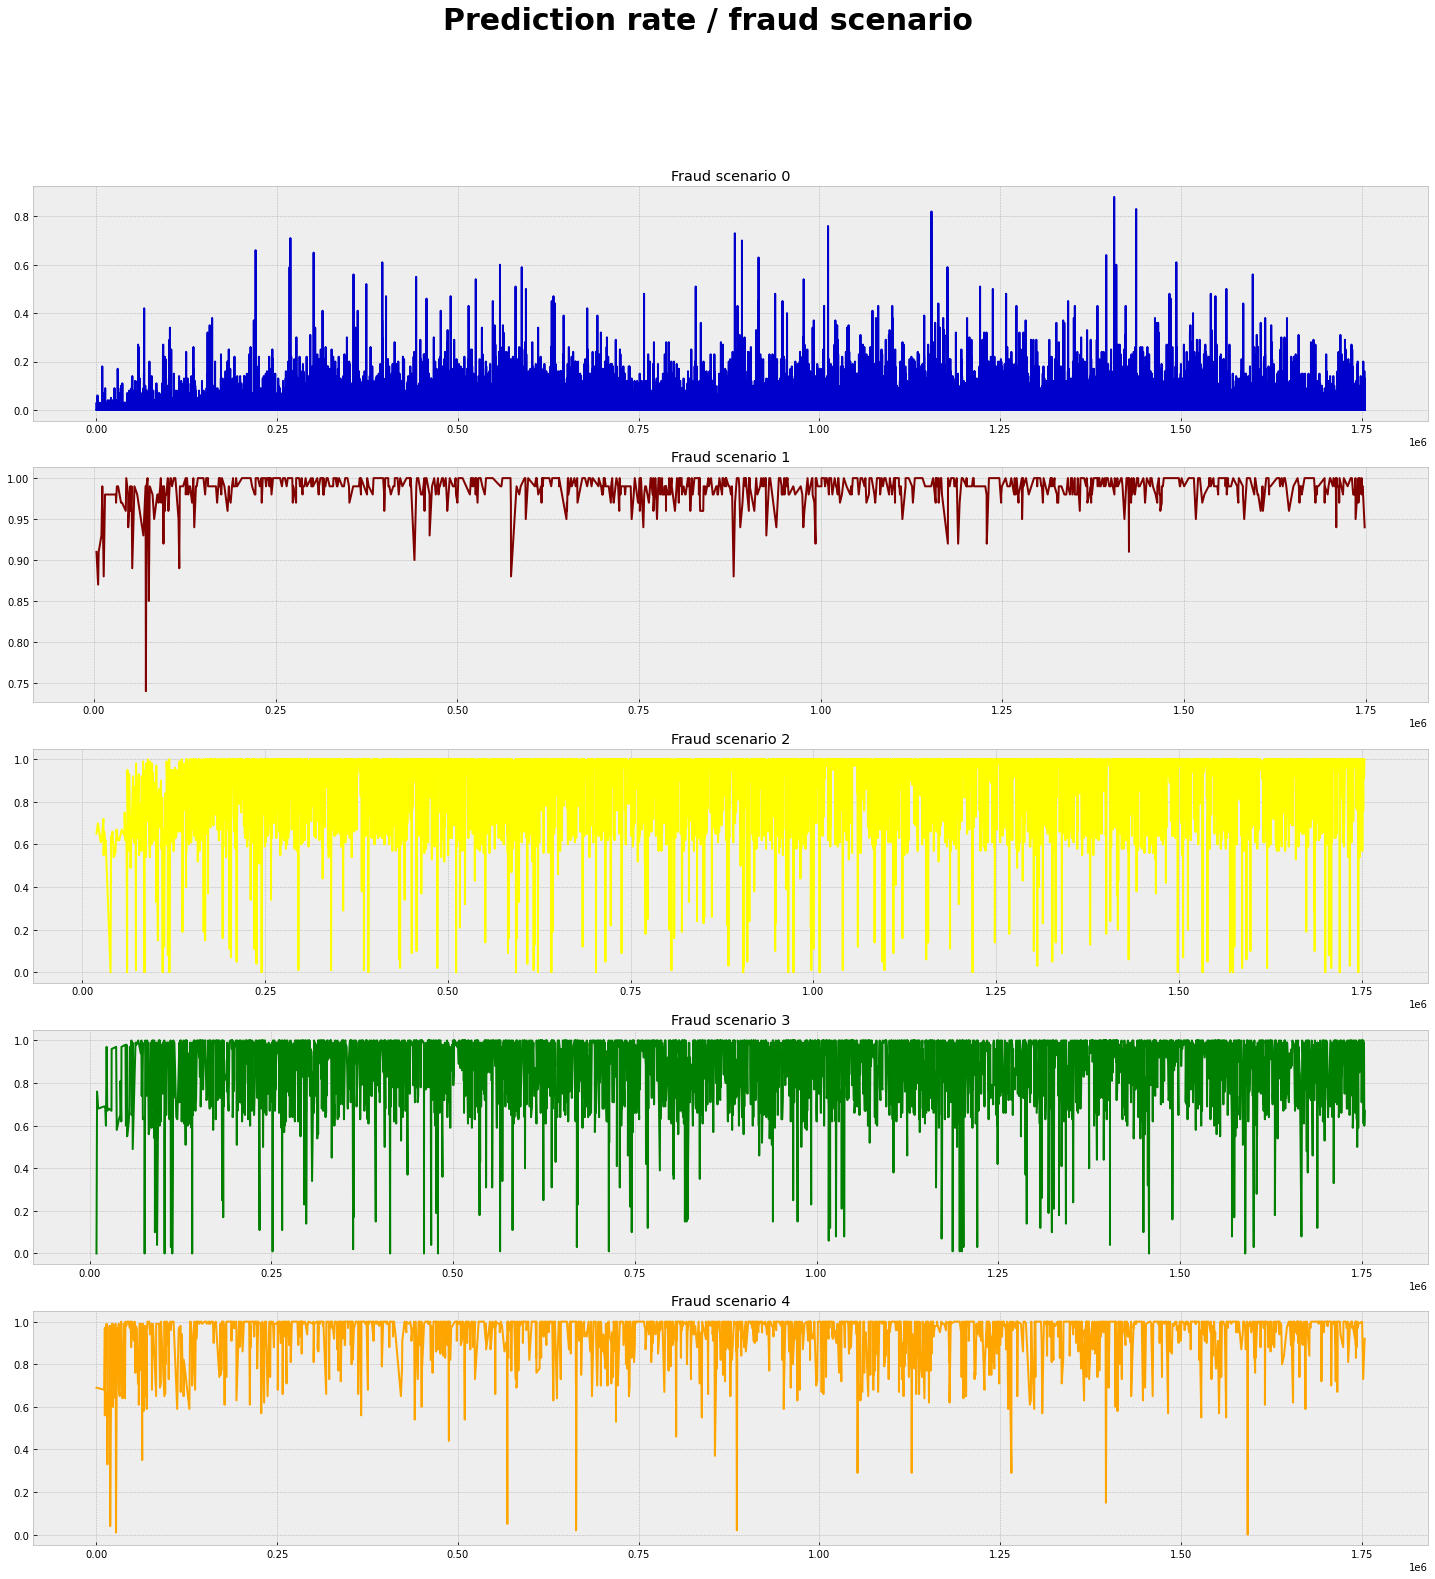

In [40]:
fig, ax=plt.subplots(5,1,figsize=(25, 25))
mplstyle.use('bmh')
fig.suptitle("Prediction rate / fraud scenario", fontsize=30, fontweight='bold')
ax[0].plot(res_scn_0.index, res_scn_0.fraud_prediction_rate, color = "mediumblue")
ax[1].plot(res_scn_1.index, res_scn_1.fraud_prediction_rate,color = "maroon")
ax[2].plot(res_scn_2.index, res_scn_2.fraud_prediction_rate,color = "yellow")
ax[3].plot(res_scn_3.index, res_scn_3.fraud_prediction_rate,color = "green")
ax[4].plot(res_scn_4.index, res_scn_4.fraud_prediction_rate,color ="orange")

ax[0].title.set_text("Fraud scenario 0")
ax[1].title.set_text("Fraud scenario 1")
ax[2].title.set_text("Fraud scenario 2")
ax[3].title.set_text("Fraud scenario 3")
ax[4].title.set_text("Fraud scenario 4")

plt.show()

Looking for fraud scenario

In [41]:
result.columns

Index(['TRANSACTION_ID', 'fraud_prediction_rate', 'fraud_prediction',
       'TX_AMOUNT', 'TX_FRAUD', 'TX_FRAUD_SCENARIO', 'false_positive',
       'fraud_missed', 'fraud_catch', 'genuine_transaction'],
      dtype='object')

In [42]:
result = result[['TRANSACTION_ID','TX_AMOUNT','TX_FRAUD_SCENARIO','TX_FRAUD','fraud_prediction',
                 'fraud_prediction_rate', 'false_positive',
                 'fraud_missed', 'fraud_catch', 'genuine_transaction']]

# Confusion matrix

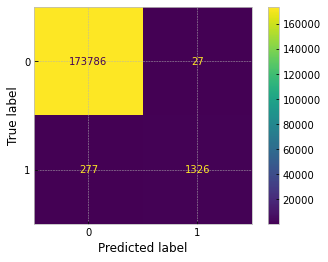

In [43]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
ax = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
ax.plot()
plt.show()



In [45]:
result.head()

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD_SCENARIO,TX_FRAUD,fraud_prediction,fraud_prediction_rate,false_positive,fraud_missed,fraud_catch,genuine_transaction
0,0,57.16,0,0,0,0.0,0,0,0,1
1,1,81.51,0,0,0,0.0,0,0,0,1
2,2,146.00,0,0,0,0.0,0,0,0,1
3,3,64.49,0,0,0,0.0,0,0,0,1
4,4,50.99,0,0,0,0.0,0,0,0,1


In [46]:
result

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD_SCENARIO,TX_FRAUD,fraud_prediction,fraud_prediction_rate,false_positive,fraud_missed,fraud_catch,genuine_transaction
0,0,57.16,0,0,0,0.0,0,0,0,1
1,1,81.51,0,0,0,0.0,0,0,0,1
2,2,146.00,0,0,0,0.0,0,0,0,1
3,3,64.49,0,0,0,0.0,0,0,0,1
4,4,50.99,0,0,0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,54.24,0,0,0,0.0,0,0,0,1
1754151,1754151,1.23,0,0,0,0.0,0,0,0,1
1754152,1754152,6.62,0,0,0,0.0,0,0,0,1
1754153,1754153,55.40,0,0,0,0.0,0,0,0,1


In [49]:
temp[temp.fraud_catch == 1].TX_AMOUNT

132208     158.05
1685410      5.89
1586500    162.20
202619     142.50
241930      37.06
            ...  
929328     234.75
967472     496.95
1306370    614.91
1558557    243.59
279118      89.69
Name: TX_AMOUNT, Length: 15747, dtype: float64

In [65]:
temp

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD_SCENARIO,TX_FRAUD,fraud_prediction,fraud_prediction_rate,false_positive,fraud_missed,fraud_catch,genuine_transaction
132208,132208,158.05,3,1,1,0.51,0,0,1,0
938602,938602,53.85,3,1,1,0.51,0,0,1,0
1685410,1685410,5.89,2,1,1,0.51,0,0,1,0
241930,241930,37.06,2,1,1,0.51,0,0,1,0
202619,202619,142.50,3,1,1,0.51,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
951307,951307,103.63,2,1,1,1.00,0,0,1,0
950827,950827,91.05,2,1,1,1.00,0,0,1,0
950161,950161,65.20,2,1,1,1.00,0,0,1,0
949984,949984,224.81,1,1,1,1.00,0,0,1,0


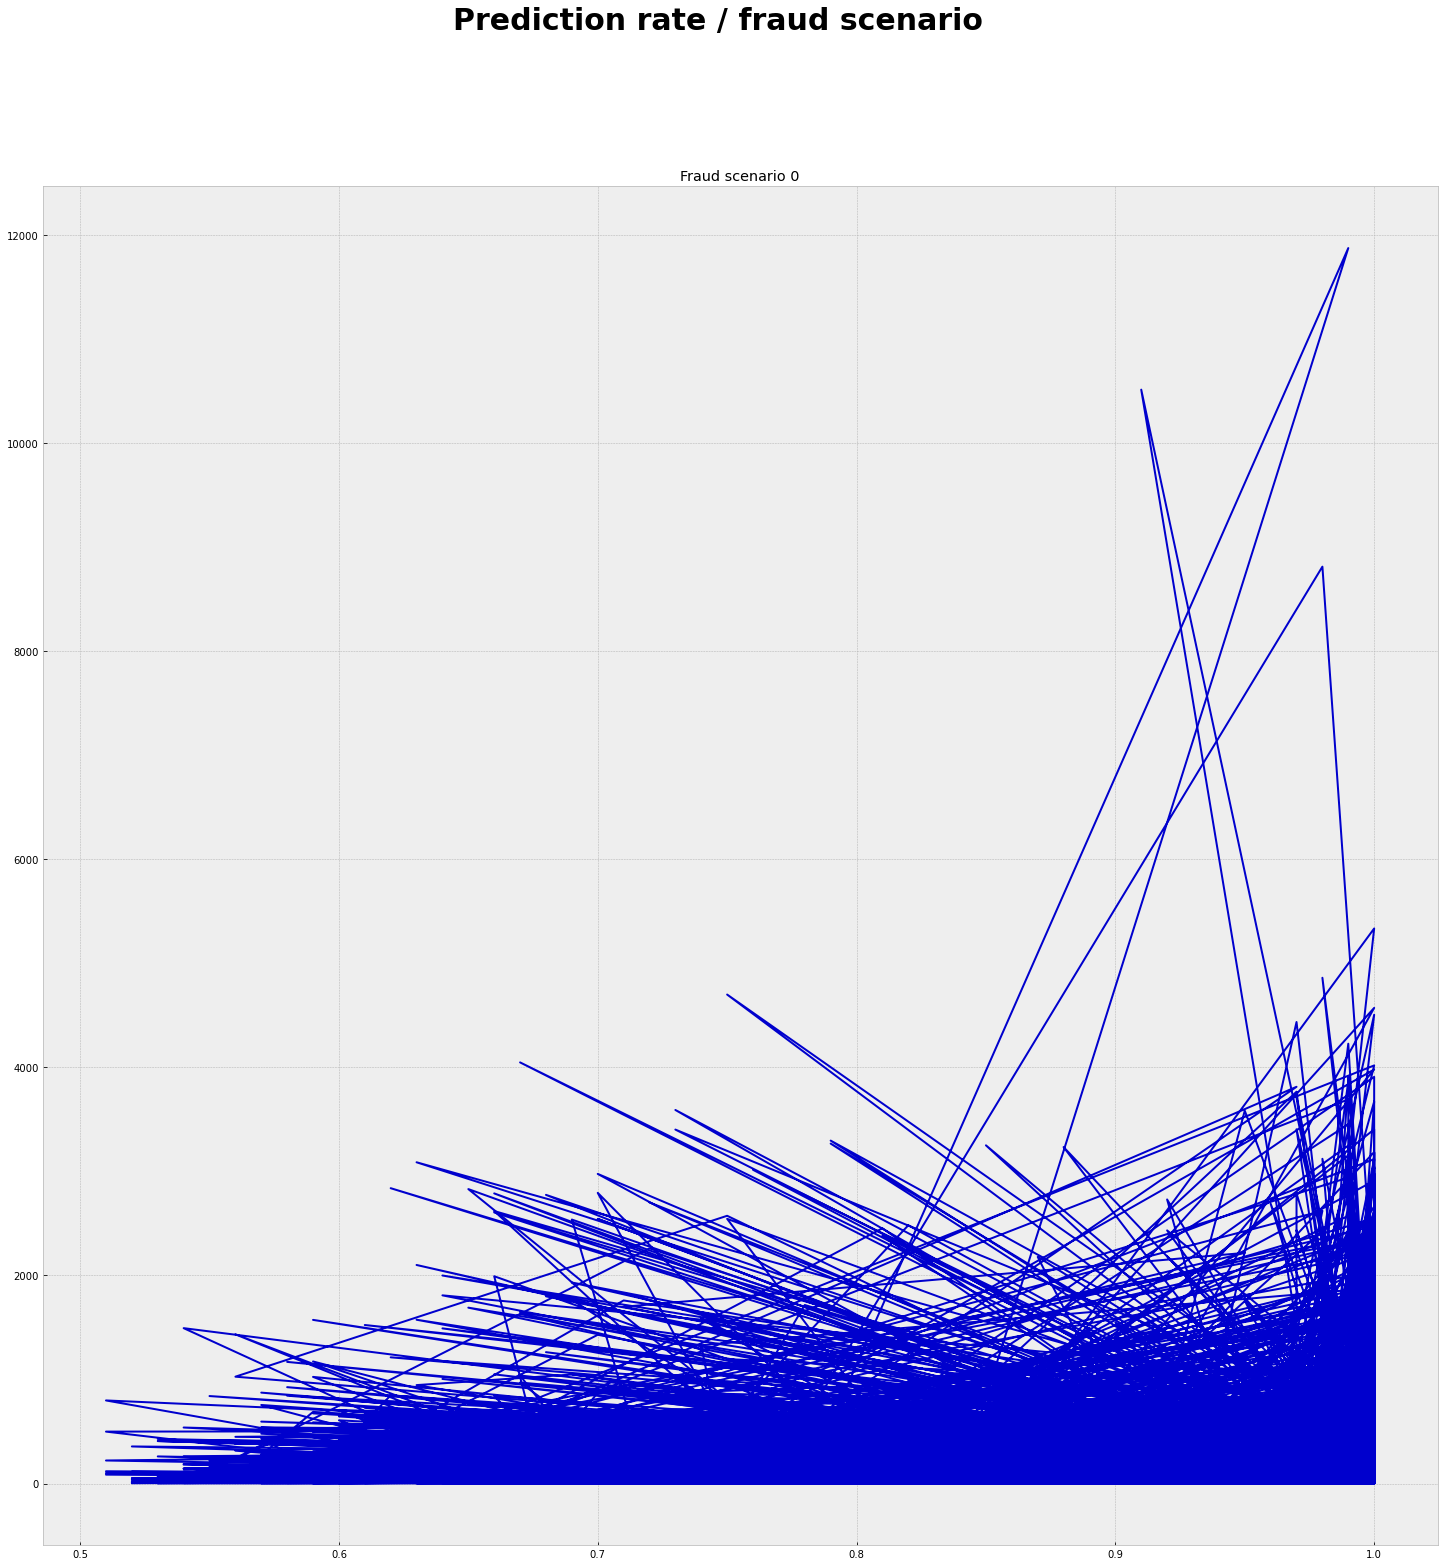

In [78]:

fig, ax=plt.subplots(figsize=(25, 25))
plt.rcParams['agg.path.chunksize'] = 10000
mplstyle.use('bmh')
fig.suptitle("Prediction rate / fraud scenario", fontsize=30, fontweight='bold')

ax.plot(result[result.fraud_catch == 1].fraud_prediction_rate,temp[temp.fraud_catch == 1].TX_AMOUNT , color = "mediumblue")


ax.title.set_text("Fraud scenario 0")

plt.show()




# engine

In [ ]:
sample_df = transactions_df.sample(10000)

sample_df = sample_df[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days']]
sample_df.head()

In [ ]:
fraud_engine_df = sample_df[0:10]

fraud_engine_df

In [ ]:
def decision_engine (pop, rating_pass,rating_review):  

    rating = model.predict_proba(pop)[:,1]
    result = []
    for score in rating:
        if score <= rating_pass:
            result.append("approved")
        elif score <= rating_review:
            result.append("review")
        elif score > rating_review:
            result.append("deny")
    fraud_engine_df["engine decision"] = result


In [ ]:
decision_engine(fraud_engine_df, 0.5, 0.7)

In [ ]:
fraud_engine_df.head()